# Solar-related cyclicity over the Holocene

## Authors

Deborah Khider [![ORCID](https://img.shields.io/badge/ORCID-0000--0001--7501--8430-A6CE39?logo=orcid)](https://orcid.org/0000-0001-7501-8430)

## Preamble

Centennial to millennial quasi-periodic oscillations appear in all manner of well-dated Holocene paleoclimate records. Though the origin of this variability is debated, the similarity between the periods recovered from the spectral analysis of Holocene paleoclimate records and corresponding reconstructions of total solar irradiance (TSI) has led to the hypothesis that TSI variations drive Holocene climate cycles (the "solar hypothesis").

In this notebook, we demonstrate the use of [the `Pyleoclim` software package](https://pyleoclim-util.readthedocs.io/en/latest/) to estimate the spectra from Holocene temperature records and estimate whether they exhibit significant periodicities in the 800-3000 year band.

Technical skills involved:

- Loading data in the [LiPD](https://lipd.net) format using the [LiPDGraph](https://linkedearth.graphdb.mint.isi.edu).
- Applying and interpreting spectral analysis in with [`Pyleoclim`](https://pyleoclim-util.readthedocs.io/en/latest/)
- Estimating significant periodicities.


### Data

The data is from the Temperature 12k Database by [Kaufman et al. (2020)](10.1038/s41597-020-0530-7), stored in the Linked PaleoData ([LiPD](https://lipd.net)) format on the [LiPDGraph](https://linkedearth.graphdb.mint.isi.edu).

### Reading time
15 min

### Keywords
Pyleoclim; LiPD; SPARQL; Holocene; Spectral Analysis.

## Data Retrieval

Following [this tutorial](http://linked.earth/pylipdTutorials/notebooks/L2_using_graphdb.html), we perform a [SPARQL](http://linked.earth/pylipdTutorials/graph.html#what-is-sparql) on the [LiPDGraph](https://linkedearth.graphdb.mint.isi.edu/) to assemble our database.

We need to return the following information for all the datasets included in the `Temp12k` compilation with the variable name `temperature`:

- `dataSetName`: The name of the dataset
- `archiveType`: The type of archive on which the measurements were made
- `Latitude`, `Longitude`, and `Elevation`: the geographical coordinates for the site
- `paleoData_variableName`: The name of the paleo variable as originally reported by the investigator
- `paleoData_standardName`: The standard name for the paleo variable (here, `temperature`)
- `paleoData_values`: The values for the paleo variable
- `paleoData_units`: The units associated with the paleo variable
- `paleoData_proxy`: The proxy used to infer paleoenvironmental conditions
- `paleoData_proxyGeneral`: Generalized grouping for proxy
- `TSiD`: The unique ID for the timeseries
- `time_variableName`: The name for the time variable. Since we are dealing with the common era, should be all “year”.
- `timevar_standardName`: The standard name for the time variable. Since we are dealing with the common era, should be all “year”. So let’s use this as a filter.
- `time_values`: The values for the time axis
- `time_units`: the units for the time axis.

The full process to query the database and ensure that the results make sense is described in the didactic notebook [Querying the LiPDGraph](query_lipd_graph.ipynb). The resulting correct query is pasted below:

In [3]:
import pandas as pd
from SPARQLWrapper import SPARQLWrapper, JSON

def fetch_sparql(endpoint_url: str, query: str) -> pd.DataFrame:
    sparql = SPARQLWrapper(endpoint_url)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()

    # Get variable names (column names)
    cols = results["head"]["vars"]

    # Build rows
    rows = []
    for result in results["results"]["bindings"]:
        row = {}
        for col in cols:
            if col in result:
                row[col] = result[col]["value"]
            else:
                row[col] = None
        rows.append(row)

    return pd.DataFrame(rows)

endpoint = "https://linkedearth.graphdb.mint.isi.edu/repositories/LiPDVerse-dynamic"
query = """PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX xml: <http://www.w3.org/XML/1998/namespace>
PREFIX dct: <http://purl.org/dc/terms/>
PREFIX le: <http://linked.earth/ontology#>
PREFIX pvar: <http://linked.earth/ontology/paleo_variables#>
PREFIX pproxy: <http://linked.earth/ontology/paleo_proxy#>
PREFIX arch: <http://linked.earth/ontology/archive#>
PREFIX punits: <http://linked.earth/ontology/paleo_units#>

SELECT
  ?TSiD
  (SAMPLE(?dataSetName) AS ?dataSetName)
  (SAMPLE(?archiveType) AS ?archiveType)
  (SAMPLE(?Latitude) AS ?Latitude)
  (SAMPLE(?Longitude) AS ?Longitude)
  (SAMPLE(?Elevation) AS ?Elevation)
  (SAMPLE(?paleoData_variableName) AS ?paleoData_variableName)
  (SAMPLE(?paleoData_standardName) AS ?paleoData_standardName)
  (SAMPLE(?paleoData_values) AS ?paleoData_values)
  (SAMPLE(?paleoData_units) AS ?paleoData_units)
  (SAMPLE(?paleoData_proxy) AS ?paleoData_proxy)
  (SAMPLE(?paleoData_proxyGeneral) AS ?paleoData_proxyGeneral)
  (SAMPLE(?time_variableName) AS ?time_variableName)
  (SAMPLE(?time_standardName) AS ?time_standardName)
  (SAMPLE(?time_values) AS ?time_values)
  (SAMPLE(?time_units) AS ?time_units)
WHERE {
  ?dataset a le:Dataset ;
           le:hasName ?dataSetName ;
           le:hasArchiveType ?archiveTypeURI ;
           le:hasLocation ?loc ;
           le:hasPaleoData ?paleoData .
  ?archiveTypeURI rdfs:label ?archiveType .

  ?loc a le:Location ;
       le:hasLatitude ?Latitude ;
       le:hasLongitude ?Longitude .
  OPTIONAL { ?loc le:hasElevation ?Elevation . }

  ?paleoData a le:PaleoData ;
             le:hasMeasurementTable ?table .
  ?table a le:DataTable .

  # Paleo variable filtered by name (temperature-like), no interpretation constraint
  ?table le:hasVariable ?paleoVar .
  ?paleoVar a le:Variable ;
            le:hasName ?paleoData_variableName ;
            le:hasValues ?paleoData_values ;
            le:hasVariableId ?TSiD ;
            le:partOfCompilation ?comp .
  FILTER(regex(?paleoData_variableName, "temp", "i"))

  OPTIONAL {
    ?paleoVar le:hasStandardVariable ?paleoData_standardNameURI .
    ?paleoData_standardNameURI rdfs:label ?paleoData_standardName .
  }
  OPTIONAL {
    ?paleoVar le:hasUnits ?paleoData_unitsURI .
    ?paleoData_unitsURI rdfs:label ?paleoData_units .
  }
  OPTIONAL {
    ?paleoVar le:hasProxy ?paleoData_proxyURI .
    ?paleoData_proxyURI rdfs:label ?paleoData_proxy .
  }
  OPTIONAL {
    ?paleoVar le:hasProxyGeneral ?paleoData_proxyGeneralURI .
    ?paleoData_proxyGeneralURI rdfs:label ?paleoData_proxyGeneral .
  }

  ?comp a le:Compilation ; le:hasName ?compName .
  FILTER(?compName = "Temp12k")

  # Associated time variable must be age (exclude year)
  ?table le:hasVariable ?timeVar .
  ?timeVar a le:Variable ;
           le:hasName ?time_variableName ;
           le:hasStandardVariable ?time_standardNameURI ;
           le:hasValues ?time_values ;
           le:hasUnits ?time_unitsURI .
  FILTER(?time_standardNameURI = pvar:age)
  ?time_standardNameURI rdfs:label ?time_standardName .
  ?time_unitsURI rdfs:label ?time_units .
}
GROUP BY ?TSiD"""
df_data = fetch_sparql(endpoint, query)
display(df_data.head())

,TSiD,dataSetName,archiveType,Latitude,Longitude,Elevation,paleoData_variableName,paleoData_standardName,paleoData_values,paleoData_units,paleoData_proxy,paleoData_proxyGeneral,time_variableName,time_standardName,time_values,time_units
0,RTdDwazy1bI,MilandreCave.Affolter.2019,Speleothem,47.49,7.02,491.0,temperature,temperature,"[8.3, 8.9, 7.7, 7.9, 8.1, 8.5, 8.1, 7.4, 7.4, ...",degC,dD,isotopic,age,age,"[-19.5, 131.5, 138.5, 146.0, 151.0, 157.0, 164...",yr BP
1,M2Lx32u25tbP,Hams.Bennett.1987,Lake sediment,43.24,-80.41,301.0,temperature,temperature,"[-6.271, -6.529, -6.229, -6.457, -5.8, -5.443,...",degC,pollen,None,age,age,"[-29, 24, 80, 136, 315, 512, 625, 753, 882, 10...",yr 14C BP
2,M2L8sc7gn3mP,Hams.Bennett.1987,Lake sediment,43.24,-80.41,301.0,temperature,temperature,"[21.229, 20.986, 21.586, 20.957, 21.729, 21.88...",degC,pollen,None,age,age,"[-29, 24, 80, 136, 315, 512, 625, 753, 882, 10...",yr 14C BP
3,M2L7thzxje2P,Hams.Bennett.1987,Lake sediment,43.24,-80.41,301.0,temperature,temperature,"[8.015, 7.7, 8.31, 7.798, 8.595, 8.849, 8.5, 8...",degC,pollen,None,age,age,"[-29, 24, 80, 136, 315, 512, 625, 753, 882, 10...",yr 14C BP
4,R3Ypu5QP5eP,EagleTarn.Rees.2010,Lake sediment,-42.6799,146.5914,1040.0,temperature,temperature,"[9.867, 9.369, 10.489, 8.589, 7.429, 7.704, 7....",degC,chironomid,None,age,age,"[29.809, 59.618, 357.708, 417.326, 506.753, 59...",yr BP


Some of the value arrays were not properly JSON encoded, so we need to create a parser to handle these use cases: 

In [6]:
import json

def safe_json_loads(row):
    if not isinstance(row, str):
        return row

    try:
        # Fast path: normal JSON
        return json.loads(row)
    except json.JSONDecodeError:
        # Slow path: fix escaped quotes
        try:
            fixed = row.replace(r'\"', '"').strip()
            return json.loads(fixed)
        except Exception:
            # Absolute fallback: mark as NaN so it doesn't break pipelines
            return np.nan

In [7]:
df = df_data.copy()

df['paleoData_values'] = df['paleoData_values'].apply(safe_json_loads)
df['time_values'] = df['time_values'].apply(safe_json_loads)

In [8]:
import numpy as np
import pandas as pd

def coerce_list_to_float_nan(v):
    if not isinstance(v, list):
        return v

    out = []
    for x in v:
        if x is None:
            out.append(np.nan)
        else:
            try:
                out.append(float(x))
            except Exception:
                out.append(np.nan)
    return out


In [9]:
df['paleoData_values'] = df['paleoData_values'].apply(coerce_list_to_float_nan)
df['time_values']      = df['time_values'].apply(coerce_list_to_float_nan)

### Importing into Pyleoclim

Let's import the data into a [`MultipleGeoseries` object](https://pyleoclim-util.readthedocs.io/en/latest/core/api.html#pyleoclim.core.multiplegeoseries.MultipleGeoSeries) for mapping purposes: 

In [10]:
import pyleoclim as pyleo

ts_list = []

for _, row in df.iterrows():
    if row['time_values'] is not None and row['paleoData_values'] is not None: #there seems to be missing entries in the database (added by DK)
        if np.all(np.isnan(row['time_values'])) == False and np.all(np.isnan(row['paleoData_values'])) == False: #check that not all the values are false (added by DK)
            ts_list.append(pyleo.GeoSeries(time=row['time_values'],value=row['paleoData_values'],
                                   time_name=row['time_variableName'],value_name=row['paleoData_variableName'],
                                   time_unit=row['time_units'], value_unit=row['paleoData_units'],
                                   lat = row['Latitude'], lon = row['Longitude'],
                                   elevation = row['Elevation'], observationType = row['paleoData_proxy'],
                                   archiveType = row['archiveType'], verbose = False, 
                                   label=row['dataSetName']+'_'+row['TSiD'])) 

temp12k = pyleo.MultipleGeoSeries(ts_list, label='Temp12k', time_unit='yr BP')

Let's map the records:

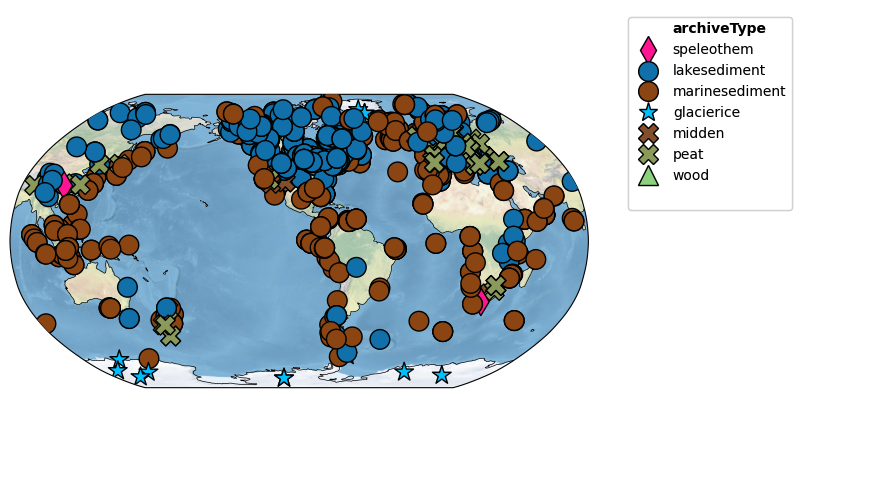

In [123]:
fig,ax = temp12k.map(projection='Robinson', figsize=[12, 6], hue='archiveType')

## Spectral Analysis

In order to identify period peaks in the various records, we will run spectral analysis. For speed, we will use the MTM method. The workflows will be as follows:
1. Slice the timeseries between 0-10,000 years
2. Ensure that the resolution is at least 300 years over this period; if not, skip
3. Cover at least 7,000 years in the Holocene; if not, skip
4. Interpolate using linear interpolation (the interpolation step is the mean spacing between consecutive points) 
5. Detrend using Empirical Mode Decomposition
6. Standardize
7. Run spectral analysis using MTM method
8. Estimate significance

Since we are interested in each GeoSeries individually, we will apply the analysis on individual records instead of the MultipleGeoSeries object:

In [11]:
psd_list = []

for idx, item in enumerate(ts_list):
    ts_slice = item.slice([0,10000])
    if ts_slice.resolution().describe()['mean'] < 300 and np.max(ts_slice.time)-np.min(ts_slice.time)>7000:
        psd_list.append(ts_slice.interp().detrend().standardize().spectral(method='mtm').signif_test(number=1000)) 
    else:      
        pass

Performing spectral analysis on individual series: 100%|██████████| 1000/1000 [00:04<00:00, 210.71it/s]
Performing spectral analysis on individual series: 100%|██████████| 1000/1000 [00:04<00:00, 216.29it/s]
Performing spectral analysis on individual series: 100%|██████████| 1000/1000 [00:03<00:00, 255.15it/s]
Performing spectral analysis on individual series: 100%|██████████| 1000/1000 [00:03<00:00, 267.58it/s]
Performing spectral analysis on individual series: 100%|██████████| 1000/1000 [00:04<00:00, 244.33it/s]
Performing spectral analysis on individual series: 100%|██████████| 1000/1000 [00:03<00:00, 278.28it/s]
Performing spectral analysis on individual series: 100%|██████████| 1000/1000 [00:04<00:00, 245.44it/s]
Performing spectral analysis on individual series: 100%|██████████| 1000/1000 [00:05<00:00, 167.45it/s]
Performing spectral analysis on individual series: 100%|██████████| 1000/1000 [00:04<00:00, 236.91it/s]
Performing spectral analysis on individual series: 100%|████████

In [131]:
print(f"This leaves us with {len(psd_list)} records")

This leaves us with 826 records


Let's reorganize the data into a DataFrame to make it easier to analyze and plot the results.

In [12]:
label = []
lat = []
lon = []
archive = []
amp =[]
period = []
unit = []
signif = []

for item in psd_list:
    label.append(item.timeseries.label)
    lat.append(item.timeseries.lat)
    lon.append(item.timeseries.lon)
    archive.append(item.timeseries.archiveType)
    amp.append(item.amplitude)
    period.append(1/item.frequency)
    unit.append(item.period_unit)
    signif.append(item.signif_qs.psd_list[0].amplitude)

# Put it in a DataFrame
df_psd = pd.DataFrame({'Name':label,
                       'Latitude':lat,
                       'Longitude':lon,
                       'Archive':archive,
                       'Amplitude':amp,
                       'Period':period,
                       'Units':unit,
                       'AR1': signif})

display(df_psd.head())

,Name,Latitude,Longitude,Archive,Amplitude,Period,Units,AR1
0,MilandreCave.Affolter.2019_RTdDwazy1bI,47.4900,7.0200,Speleothem,"[nan, 297.86273293454246, 491.1713902734278, 5...","[inf, 9842.499999999967, 4921.249999999984, 32...",yr,"[nan, 530.3846300489174, 483.5699767944426, 43..."
1,Hams.Bennett.1987_M2Lx32u25tbP,43.2400,-80.4100,Lake sediment,"[nan, 446.3995208636168, 475.273075214222, 370...","[inf, 9947.999999999998, 4973.999999999999, 33...",yr,"[nan, 804.5016670211398, 738.3603658312031, 67..."
2,Hams.Bennett.1987_M2L8sc7gn3mP,43.2400,-80.4100,Lake sediment,"[nan, 807.4810157740312, 971.2050077843061, 97...","[inf, 9947.999999999998, 4973.999999999999, 33...",yr,"[nan, 1662.0424674531814, 1500.121930781746, 1..."
3,Hams.Bennett.1987_M2L7thzxje2P,43.2400,-80.4100,Lake sediment,"[nan, 1054.455514080586, 1193.3324093048109, 1...","[inf, 9947.999999999998, 4973.999999999999, 33...",yr,"[nan, 1932.9557075930925, 1814.2640366814185, ..."
4,EagleTarn.Rees.2010_R3Ypu5QP5eP,-42.6799,146.5914,Lake sediment,"[nan, 590.4217629024698, 573.882011815157, 667...","[inf, 9924.615000000003, 4962.307500000002, 33...",yr,"[nan, 1749.2918355376432, 1581.2566802323404, ..."


Since this takes quite a bit of time to run, let's pickle the file:

In [13]:
import pickle

with open("../data/temp12k_peaks.pkl", "wb") as f:   # 'wb' = write binary
    pickle.dump(df_psd, f)

In [14]:
with open("../data/temp12k_psd.pkl", "wb") as f:   # 'wb' = write binary
    pickle.dump(psd_list, f)

## Chasing cyclicities over the Holocene.

First, let's have a look at some of the spectra generated in the previous step. We will regenerate 12 random periodograms.

In [1]:
import pickle

with open("../data/temp12k_peaks.pkl", "rb") as f:   # 'rb' = read binary
    df_psd = pickle.load(f)

with open("../data/temp12k_psd.pkl", "rb") as f:   # 'wb' = read binary
    psd_list = pickle.load(f)

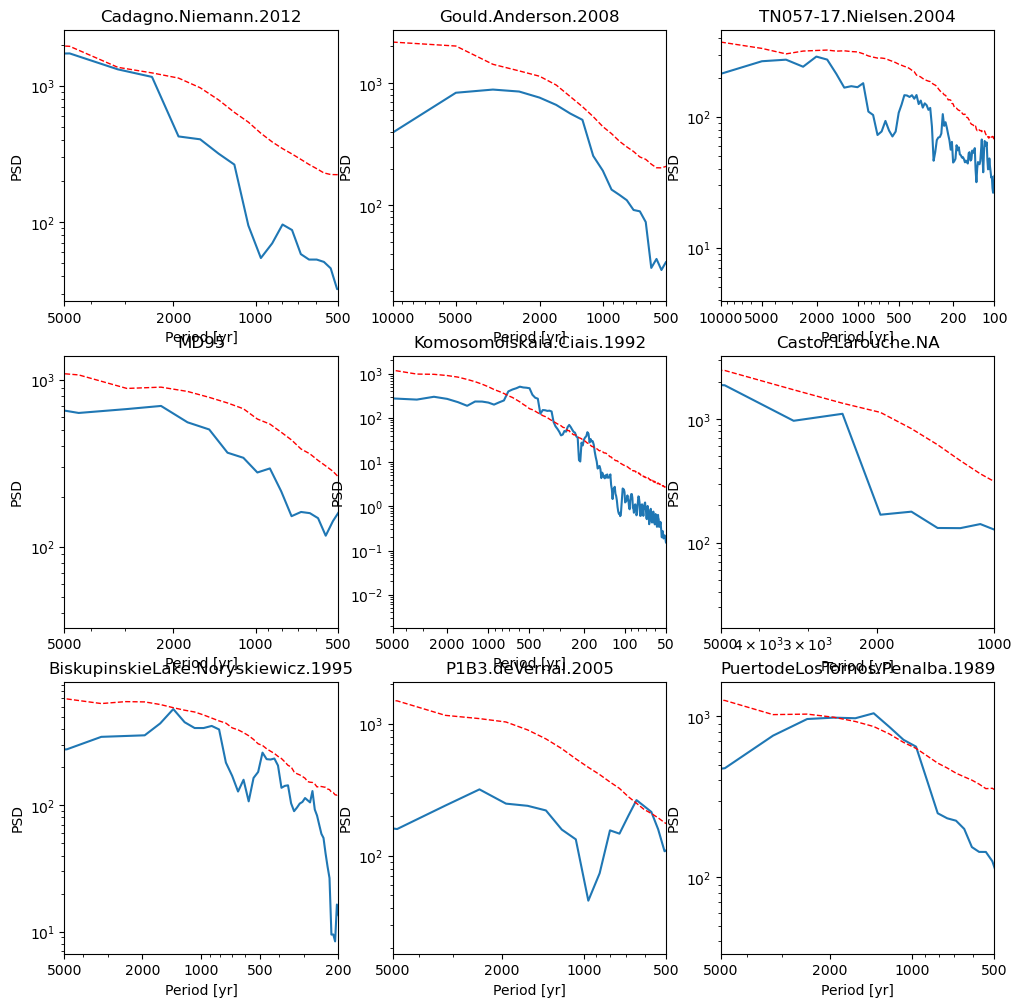

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pyleoclim as pyleo

rng = np.random.default_rng(42) #set a seed for reproducibility. 42 is the answer to everything
random_values = rng.permutation(len(df_psd))[0:9]

# Create the figure and set of subplots
fig,ax = plt.subplots(3,3, figsize = (12,12))

k = 0
for i in range(3):
    for j in range(3):
        val = random_values[k]
        psd = psd_list[val]

        # deal with the title
        lbl = psd.timeseries.label.split('_')[0]

        psd.plot(
            title=lbl,
            ax=ax[i, j],
            legend = False
        )
        k += 1


Some records display millennial-scale periodicities over the Holocene but very few are significant about red noise (defined here at 95% CI). 

Let's have a closer look at the number of records with significant peaks corresponding to periodicities in the 800-3000 year range. 

In [9]:
import numpy as np
import pandas as pd

def find_red_noise_peaks(period, amplitude, ar1,
                         pmin=800, pmax=3000):
    """
    Return indices of peaks above red noise
    within a given period band.
    """
    period = np.asarray(period, dtype=float)
    amplitude = np.asarray(amplitude, dtype=float)
    ar1 = np.asarray(ar1, dtype=float)

    # Mask invalid values
    valid = (
        np.isfinite(period) &
        np.isfinite(amplitude) &
        np.isfinite(ar1)
    )

    period = period[valid]
    amplitude = amplitude[valid]
    ar1 = ar1[valid]

    # Period band
    band = (period >= pmin) & (period <= pmax)

    # Above red noise
    significant = amplitude > ar1

    mask = band & significant

    return period[mask], amplitude[mask], ar1[mask]

In [11]:
df_peaks = df_psd.copy()

df_peaks[["sig_periods", "sig_amplitudes", "sig_ar1"]] = (
    df_peaks.apply(
        lambda row: pd.Series(
            find_red_noise_peaks(
                row["Period"],
                row["Amplitude"],
                row["AR1"]
            )
        ),
        axis=1
    )
)

display(df_peaks.head())

,Name,Latitude,Longitude,Archive,Amplitude,Period,Units,AR1,sig_periods,sig_amplitudes,sig_ar1
0,MilandreCave.Affolter.2019_RTdDwazy1bI,47.4900,7.0200,Speleothem,"[nan, 297.86273293454246, 491.1713902734278, 5...","[inf, 9842.499999999967, 4921.249999999984, 32...",yr,"[nan, 530.3846300489174, 483.5699767944426, 43...","[2460.624999999992, 1968.4999999999934, 1640.4...","[549.1074872980157, 569.837630158562, 565.6923...","[474.3976517401739, 476.6902586351101, 463.563..."
1,Hams.Bennett.1987_M2Lx32u25tbP,43.2400,-80.4100,Lake sediment,"[nan, 446.3995208636168, 475.273075214222, 370...","[inf, 9947.999999999998, 4973.999999999999, 33...",yr,"[nan, 804.5016670211398, 738.3603658312031, 67...",[],[],[]
2,Hams.Bennett.1987_M2L8sc7gn3mP,43.2400,-80.4100,Lake sediment,"[nan, 807.4810157740312, 971.2050077843061, 97...","[inf, 9947.999999999998, 4973.999999999999, 33...",yr,"[nan, 1662.0424674531814, 1500.121930781746, 1...",[],[],[]
3,Hams.Bennett.1987_M2L7thzxje2P,43.2400,-80.4100,Lake sediment,"[nan, 1054.455514080586, 1193.3324093048109, 1...","[inf, 9947.999999999998, 4973.999999999999, 33...",yr,"[nan, 1932.9557075930925, 1814.2640366814185, ...",[],[],[]
4,EagleTarn.Rees.2010_R3Ypu5QP5eP,-42.6799,146.5914,Lake sediment,"[nan, 590.4217629024698, 573.882011815157, 667...","[inf, 9924.615000000003, 4962.307500000002, 33...",yr,"[nan, 1749.2918355376432, 1581.2566802323404, ...",[],[],[]


Let's flatten the DataFrame to one row per peak:

In [13]:
rows = []

for _, row in df_peaks.iterrows():
    for p, a, r in zip(row["sig_periods"],
                       row["sig_amplitudes"],
                       row["sig_ar1"]):
        rows.append({
            "Latitude": row["Latitude"],
            "Longitude": row["Longitude"],
            "Archive": row["Archive"],
            "Period": p,
            "Amplitude": a,
            "AR1": r
        })

df_peaks_flat = pd.DataFrame(rows)


Let's derive some statistical information:

In [14]:
df_peaks_flat["Period"].describe()


count     448.000000
mean     1480.177263
std       550.189804
min       809.515794
25%      1063.593730
50%      1336.543584
75%      1748.613188
max      2997.081231
Name: Period, dtype: float64

### Global view of significant millennial periodicities. 

Let's create a simple histograms of the identified peaks:

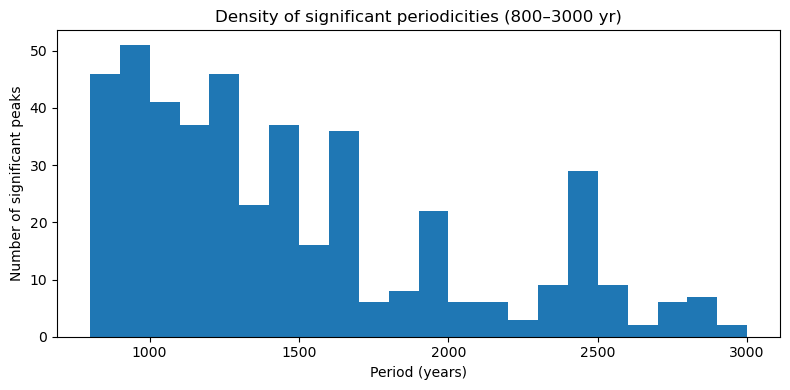

In [18]:
import numpy as np

mask = (
    np.isfinite(df_peaks_flat["Period"]) &
    (df_peaks_flat["Period"] >= 800) &
    (df_peaks_flat["Period"] <= 3000)
)

df_peaks_flat = df_peaks_flat.loc[mask].copy() #make sure that nothing weird happened during flattening

import matplotlib.pyplot as plt

bins = np.arange(800, 3000 + 100, 100)

plt.figure(figsize=(8, 4))
plt.hist(df_peaks_flat["Period"], bins=bins)
plt.xlabel("Period (years)")
plt.ylabel("Number of significant peaks")
plt.title("Density of significant periodicities (800–3000 yr)")
plt.tight_layout()
plt.show()

Also let's see if some sites contribute more information than others:

In [19]:
df_peaks_flat.groupby(["Latitude", "Longitude"]).size().describe()

count    155.000000
mean       2.890323
std        2.587602
min        1.000000
25%        1.000000
50%        2.000000
75%        4.000000
max       17.000000
dtype: float64

On average, each site has 2-3 peaks in the millennial band. Let's map the number of peaks for each record:

In [27]:
import pandas as pd

df_peak_counts = (
    df_peaks_flat
    .groupby(["Latitude", "Longitude", "Archive"])
    .size()
    .reset_index(name="n_peaks")
)

In [30]:
df_peak_counts['Archive'].unique()

array(['Glacier ice', 'Marine sediment', 'Midden', 'Peat',
       'Lake sediment', 'Speleothem', 'Wood'], dtype=object)

In [34]:
archive_markers = {
    "Glacier ice": "^",        
    "Marine sediment": "s",          
    "Midden": "v",    
    "Peat": "<",           
    "Lake sediment": "D",
    "Speleothem": '*',
    "Wood" : 'o'}      

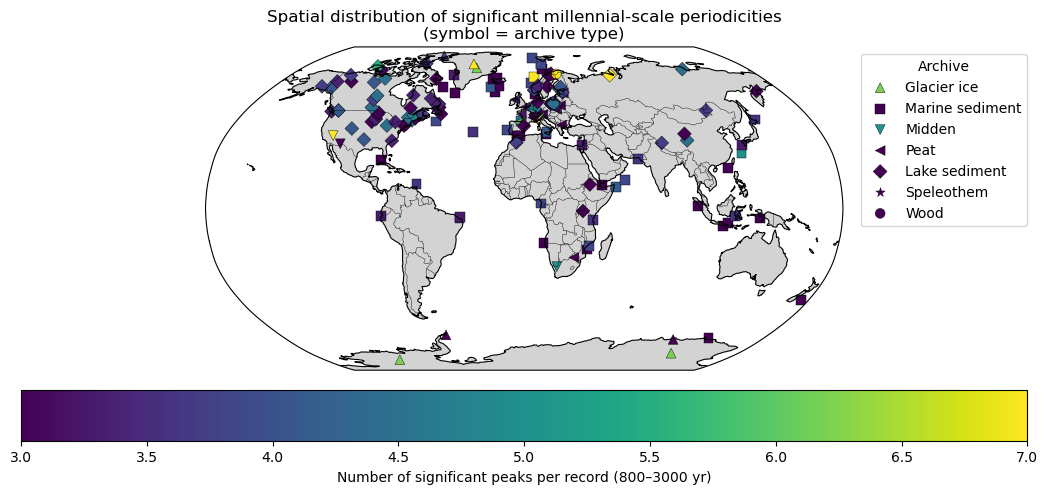

In [47]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig = plt.figure(figsize=(11, 5))
ax = plt.axes(projection=ccrs.Robinson())

ax.set_global()
ax.coastlines(linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linewidth=0.3)
ax.add_feature(cfeature.LAND, facecolor="lightgray")
ax.add_feature(cfeature.OCEAN, facecolor="white")

for archive, marker in archive_markers.items():
    subset = df_peak_counts[df_peak_counts["Archive"] == archive]

    if subset.empty:
        continue

    sc = ax.scatter(
        subset["Longitude"],
        subset["Latitude"],
        c=subset["n_peaks"],
        s=50,
        #s = 20 + 10 * subset["n_peaks"],
        cmap="viridis",
        marker=marker,
        transform=ccrs.PlateCarree(),
        edgecolor="k",
        linewidth=0.3,
        label=archive
    )

# Colorbar (shared)
cbar = plt.colorbar(sc, ax=ax, orientation="horizontal", pad=0.05)
cbar.set_label("Number of significant peaks per record (800–3000 yr)")

# Legend for archive types
ax.legend(
    title="Archive",
    bbox_to_anchor=(1.3, 1),
    loc="upper right",
    frameon=True
)

plt.title("Spatial distribution of significant millennial-scale periodicities\n(symbol = archive type)")
plt.tight_layout()
plt.show()


### Periodicities by latitude and archive

In [48]:
import numpy as np
import pandas as pd

df_lp = df_peaks_flat.copy()

mask = (
    np.isfinite(df_lp["Period"]) &
    np.isfinite(df_lp["Latitude"]) &
    (df_lp["Period"] >= 800) &
    (df_lp["Period"] <= 3000)
)

df_lp = df_lp.loc[mask].copy()

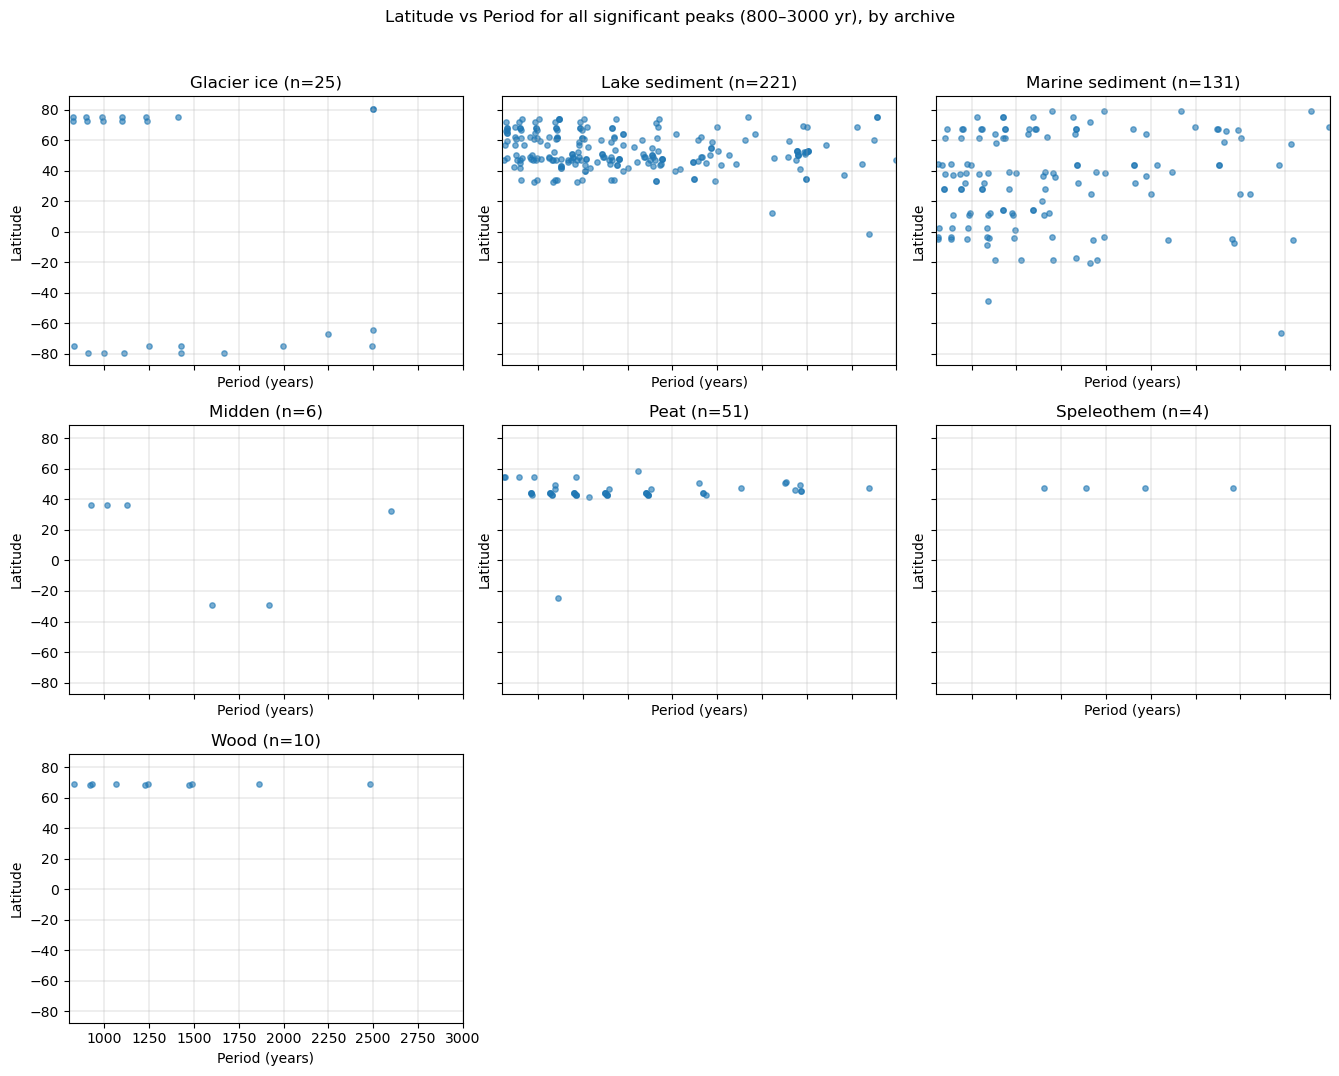

In [49]:
import matplotlib.pyplot as plt
import numpy as np

archives = sorted(df_lp["Archive"].dropna().unique())
n = len(archives)

ncols = 3 if n >= 3 else n
nrows = int(np.ceil(n / ncols))

fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(4.5 * ncols, 3.5 * nrows),
    sharex=True,
    sharey=True
)

axes = np.atleast_1d(axes).ravel()

for ax, arch in zip(axes, archives):
    sub = df_lp[df_lp["Archive"] == arch]

    ax.scatter(
        sub["Period"],
        sub["Latitude"],
        s=15,
        alpha=0.6
    )

    ax.set_title(f"{arch} (n={len(sub)})")
    ax.grid(True, linewidth=0.3)

# Turn off unused panels
for ax in axes[len(archives):]:
    ax.axis("off")

for ax in axes[:len(archives)]:
    ax.set_xlim(800, 3000)
    ax.set_xlabel("Period (years)")
    ax.set_ylabel("Latitude")

fig.suptitle(
    "Latitude vs Period for all significant peaks (800–3000 yr), by archive",
    y=1.02
)

plt.tight_layout()
plt.show()


Let's redo this figure but use color to indicate how much above red noise the peaks are:

In [52]:
import numpy as np

df_lp = df_peaks_flat.copy()

mask = (
    np.isfinite(df_lp["Period"]) &
    np.isfinite(df_lp["Latitude"]) &
    np.isfinite(df_lp["Amplitude"]) &
    np.isfinite(df_lp["AR1"]) &
    (df_lp["Period"] >= 800) & (df_lp["Period"] <= 3000) &
    (df_lp["AR1"] > 0)
)

df_lp = df_lp.loc[mask].copy()
df_lp["strength"] = df_lp["Amplitude"] / df_lp["AR1"]

df_lp = df_lp[np.isfinite(df_lp["strength"])].copy()

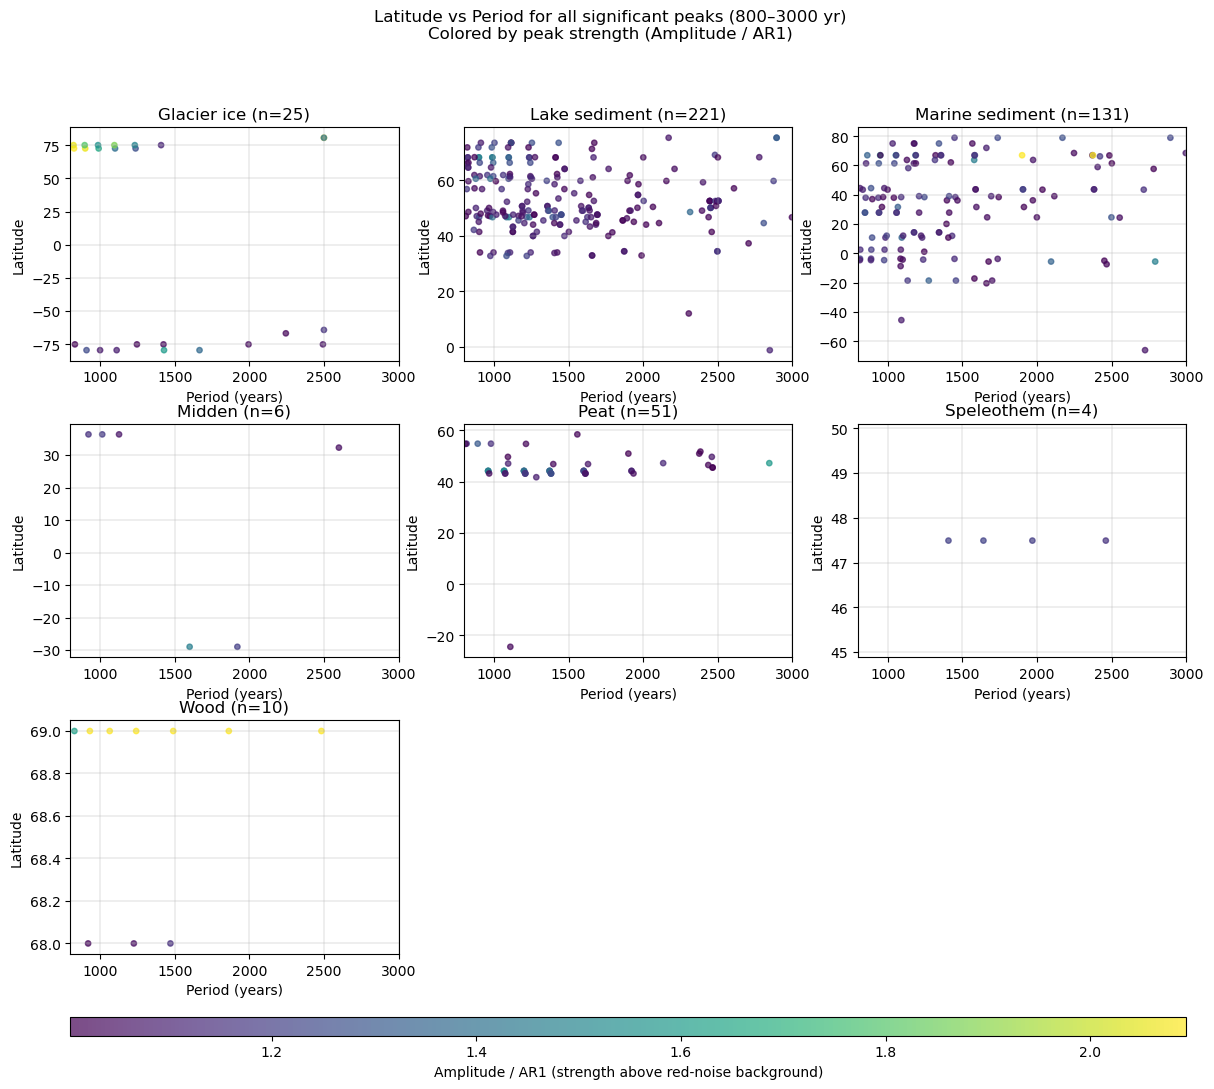

In [53]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec

archives = sorted(df_lp["Archive"].dropna().unique())
n = len(archives)

ncols = 3
nrows = int(np.ceil(n / ncols))

fig = plt.figure(figsize=(4.8 * ncols, 3.6 * nrows + 1.0))
gs = GridSpec(nrows + 1, ncols, height_ratios=[1]*nrows + [0.08], hspace=0.35)

axes = []
for i in range(nrows):
    for j in range(ncols):
        axes.append(fig.add_subplot(gs[i, j]))

# Robust linear color limits
vmin, vmax = np.nanpercentile(df_lp["strength"], [2, 98])

mappable = None
for ax, arch in zip(axes, archives):
    sub = df_lp[df_lp["Archive"] == arch]

    mappable = ax.scatter(
        sub["Period"],
        sub["Latitude"],
        c=sub["strength"],
        s=15,
        alpha=0.7,
        vmin=vmin,
        vmax=vmax
    )

    ax.set_title(f"{arch} (n={len(sub)})")
    ax.grid(True, linewidth=0.3)
    ax.set_xlim(800, 3000)
    ax.set_xlabel("Period (years)")
    ax.set_ylabel("Latitude")

# Turn off unused axes
for ax in axes[len(archives):]:
    ax.axis("off")

# Colorbar axis spanning all columns
cax = fig.add_subplot(gs[-1, :])
cbar = fig.colorbar(mappable, cax=cax, orientation="horizontal")
cbar.set_label("Amplitude / AR1 (strength above red-noise background)")

fig.suptitle(
    "Latitude vs Period for all significant peaks (800–3000 yr)\nColored by peak strength (Amplitude / AR1)",
    y=0.98
)

plt.show()


There is no significant peaks clustering at a specific periodicity across latitude/archives. 